<a href="https://colab.research.google.com/gist/yuandahanif/4b3160ccac0731fabc10c1a94996962b/untitled1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hands-on Transfer Learning with Keras and the VGG16 Model
[Referensi](https://www.learndatasci.com/tutorials/hands-on-transfer-learning-keras/)


Apa yang akan kita lakukan dan harusnya bisa kita lakukan pada akhir pembelajaran ini


* Mendownload sebuah model pre-trained dari keras untuk transfer learning
* Sempurnakan model yang telah dilatih sebelumnya pada kumpulan data khusus

Lalu apa itu Transfer Learning ?

Model harus terlebih dahulu belajar mengenali fitur umum gambar, seperti tepi dan titik warna, sebelum mengenali fitur yang lebih kompleks.

Dalam aplikasi nyata, mencapai kinerja tinggi membutuhkan latihan berhari-hari dan jutaan gambar. Akan lebih mudah bagi kami untuk mengunduh model pra-terlatih generik dan melatihnya kembali di kumpulan data kami sendiri. Inilah yang dimaksud dengan transfer learning.

Dengan cara ini, transfer learning adalah pendekatan di mana kami mengambil model yang telah dilatih untuk tugas pembelajaran mesin dan menggunakannya kembali sebagai titik awal untuk tugas yang berbeda. Beberapa bidang pembelajaran mendalam menggunakan pendekatan ini, termasuk klasifikasi gambar, pemrosesan bahasa alami, dan bahkan permainan! Kemampuan untuk menyesuaikan model terlatih dengan tugas lain sangat berharga.


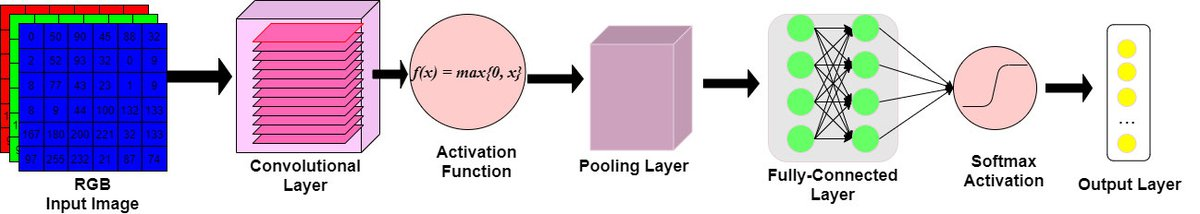

In [4]:
#CNN Review

#Diharapkan dari tutorial ini kita dapat memiliki pemahaman tentang convolutional neural network.

#Convolutional Neural Network Architecture
from IPython.display import Image
Image(filename='index.jpeg')

Mengingat kembali bahwa arsitektur CNN memiliki beberapa blok yang penting seperti:

    1.Convolutional Layer
    2.ReLu (Activation) Layer
    3.Pooling Layer
    4.Fully-Connected Layer

Kita akan memuat model yang sama seperti sebelumnya untuk menghasilkan beberapa prediksi dan menghitung keakuratannya, yang akan digunakan untuk membandingkan kinerja model baru menggunakan Transfer Learning


## Memperisapkan dataset
unduh dataset dari tautan [berikut](http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz)
kemudian ekstrak.

In [23]:
import pandas as pd 

# !cd ..
# !wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
# !tar xzf food-101.tar.gz
# !rm -rf 'food-101.tar.gz'
# !pip install livelossplot --quiet

Selanjutnya split atau pisahkan dataset training dan testing menggunakan fungsi berikut.

In [11]:
# Move data from images to images/train or images/test: 
import shutil
from collections import defaultdict
import json
from pathlib import Path
import os

def split_dataset(root_food_path):
    """Takes in the path for food-101 directory and creates train/test dirs of images"""
    data_paths = {
        'train': root_food_path/'meta/train.json',
        'test': root_food_path/'meta/test.json'
    }

    for data_type, meta_path in data_paths.items():
        # Make the train/test dirs
        os.makedirs(root_food_path/data_type, exist_ok=True)
        
        # Read the meta files. 
        # These are loaded as a dict of food names with a list of image paths
        # E.g. {"<food_name>": ["<food_name>/<image_num>", ...], ...}
        food_images = json.load(open(meta_path, 'r'))
        
        for food_name, image_paths in food_images.items():
            # Make food dir in train/test dir
            os.makedirs(root_food_path/data_type/food_name, exist_ok=True)
            
            # Move images from food-101/images to food-101/train (or test)
            for image_path in image_paths:
                image_path = image_path + '.jpg'
                shutil.move(root_food_path/'images'/image_path, root_food_path/data_type/image_path)

Load semua modul yang dibutuhkan

In [12]:
import os
from keras.models import Model
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten
from pathlib import Path

In [13]:
download_dir = Path('./')

# call this function first time/one time only -- already called
# split_dataset(download_dir/'food-101')

In [14]:
BATCH_SIZE = 64
train_generator = ImageDataGenerator(rotation_range=90, 
                                     brightness_range=[0.1, 0.7],
                                     width_shift_range=0.5, 
                                     height_shift_range=0.5,
                                     horizontal_flip=True, 
                                     vertical_flip=True,
                                     validation_split=0.15,
                                     preprocessing_function=preprocess_input) # VGG16 preprocessing

test_generator = ImageDataGenerator(preprocessing_function=preprocess_input) # VGG16 preprocessing

In [15]:
train_data_dir = download_dir/'food-101/train'
test_data_dir = download_dir/'food-101/test'

class_subset = sorted(os.listdir(download_dir/'food-101/images'))[:10] # Using only the first 10 classes

traingen = train_generator.flow_from_directory(train_data_dir,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               classes=class_subset,
                                               subset='training',
                                               batch_size=BATCH_SIZE, 
                                               shuffle=True,
                                               seed=42)

validgen = train_generator.flow_from_directory(train_data_dir,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               classes=class_subset,
                                               subset='validation',
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               seed=42)

testgen = test_generator.flow_from_directory(test_data_dir,
                                             target_size=(224, 224),
                                             class_mode=None,
                                             classes=class_subset,
                                             batch_size=1,
                                             shuffle=False,
                                             seed=42)

Found 6380 images belonging to 10 classes.
Found 1120 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


## Using Pre-trained Layers for Feature Extraction

In [16]:
def create_model(input_shape, n_classes, optimizer='rmsprop', fine_tune=0):
    """
    Compiles a model integrated with VGG16 pretrained layers
    
    input_shape: tuple - the shape of input images (width, height, channels)
    n_classes: int - number of classes for the output layer
    optimizer: string - instantiated optimizer to use for training. Defaults to 'RMSProp'
    fine_tune: int - The number of pre-trained layers to unfreeze.
                If set to 0, all pretrained layers will freeze during training
    """
    
    # Pretrained convolutional layers are loaded using the Imagenet weights.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.
    conv_base = VGG16(include_top=False,
                     weights='imagenet', 
                     input_shape=input_shape)
    
    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    # Create a new 'top' of the model (i.e. fully-connected layers).
    # This is 'bootstrapping' a new top_model onto the pretrained layers.
    top_model = conv_base.output
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(4096, activation='relu')(top_model)
    top_model = Dense(1072, activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)
    output_layer = Dense(n_classes, activation='softmax')(top_model)
    
    # Group the convolutional base and new fully-connected layers into a Model object.
    model = Model(inputs=conv_base.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

### Training Without Fine-Tuning

In [17]:
input_shape = (224, 224, 3)
optim_1 = Adam(learning_rate=0.001)
n_classes=10

n_steps = traingen.samples // BATCH_SIZE
n_val_steps = validgen.samples // BATCH_SIZE
n_epochs = 50

# First we'll train the model without Fine-tuning
vgg_model = create_model(input_shape, n_classes, optim_1, fine_tune=0)

58889256/58889256 [==============================] - 3s 0us/step


In [20]:
from livelossplot.inputs.keras import PlotLossesCallback

plot_loss_1 = PlotLossesCallback()

# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(filepath='tl_model_v1.weights.best.hdf5',
                                  save_best_only=True,
                                  verbose=1)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

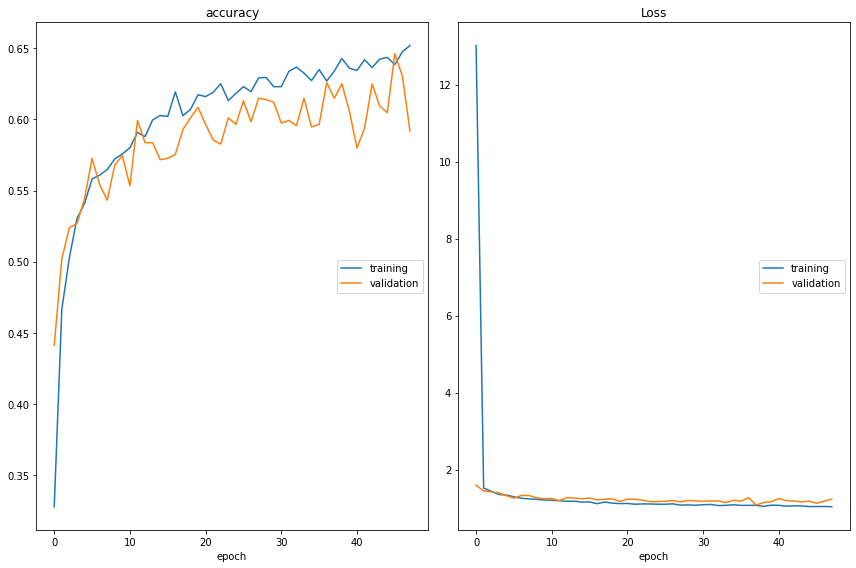

accuracy
	training         	 (min:    0.328, max:    0.652, cur:    0.652)
	validation       	 (min:    0.441, max:    0.646, cur:    0.592)
Loss
	training         	 (min:    1.034, max:   13.017, cur:    1.034)
	validation       	 (min:    1.079, max:    1.592, cur:    1.233)
99/99 [==============================] - 123s 1s/step - loss: 1.0340 - accuracy: 0.6520 - val_loss: 1.2331 - val_accuracy: 0.5919
CPU times: user 1h 44min 2s, sys: 1min 51s, total: 1h 45min 54s
Wall time: 1h 47min 13s


In [21]:
%%time 

vgg_history = vgg_model.fit(traingen,
                            batch_size=BATCH_SIZE,
                            epochs=n_epochs,
                            validation_data=validgen,
                            steps_per_epoch=n_steps,
                            validation_steps=n_val_steps,
                            callbacks=[tl_checkpoint_1, early_stop, plot_loss_1],
                            verbose=1)

In [26]:
import numpy as np
# Generate predictions
vgg_model.load_weights('tl_model_v1.weights.best.hdf5') # initialize the best trained weights

true_classes = testgen.classes
class_indices = traingen.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

vgg_preds = vgg_model.predict(testgen)
vgg_pred_classes = np.argmax(vgg_preds, axis=1)

2500/2500 [==============================] - 27s 11ms/step


In [27]:
from sklearn.metrics import accuracy_score

vgg_acc = accuracy_score(true_classes, vgg_pred_classes)
print("VGG16 Model Accuracy without Fine-Tuning: {:.2f}%".format(vgg_acc * 100))

VGG16 Model Accuracy without Fine-Tuning: 72.32%


### Using Pre-trained Layers for Fine-Tuning

In [28]:
# Reset our image data generators
traingen.reset()
validgen.reset()
testgen.reset()

# Use a smaller learning rate
optim_2 = Adam(lr=0.0001)

# Re-compile the model, this time leaving the last 2 layers unfrozen for Fine-Tuning
vgg_model_ft = create_model(input_shape, n_classes, optim_2, fine_tune=2)

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


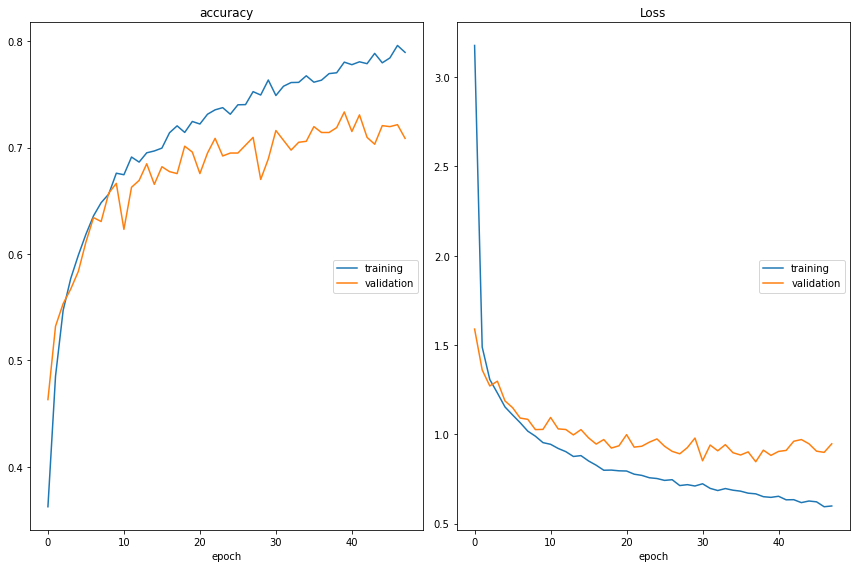

accuracy
	training         	 (min:    0.363, max:    0.796, cur:    0.789)
	validation       	 (min:    0.463, max:    0.733, cur:    0.709)
Loss
	training         	 (min:    0.594, max:    3.177, cur:    0.599)
	validation       	 (min:    0.846, max:    1.589, cur:    0.947)
99/99 [==============================] - 124s 1s/step - loss: 0.5986 - accuracy: 0.7894 - val_loss: 0.9467 - val_accuracy: 0.7086
CPU times: user 1h 45min 30s, sys: 1min 47s, total: 1h 47min 17s
Wall time: 1h 46min 57s


In [29]:
%%time

plot_loss_2 = PlotLossesCallback()

# Retrain model with fine-tuning
vgg_ft_history = vgg_model_ft.fit(traingen,
                                  batch_size=BATCH_SIZE,
                                  epochs=n_epochs,
                                  validation_data=validgen,
                                  steps_per_epoch=n_steps, 
                                  validation_steps=n_val_steps,
                                  callbacks=[tl_checkpoint_1, early_stop, plot_loss_2],
                                  verbose=1)

In [30]:
# Generate predictions
vgg_model_ft.load_weights('tl_model_v1.weights.best.hdf5') # initialize the best trained weights

vgg_preds_ft = vgg_model_ft.predict(testgen)
vgg_pred_classes_ft = np.argmax(vgg_preds_ft, axis=1)

2500/2500 [==============================] - 30s 12ms/step


In [31]:
vgg_acc_ft = accuracy_score(true_classes, vgg_pred_classes_ft)
print("VGG16 Model Accuracy with Fine-Tuning: {:.2f}%".format(vgg_acc_ft * 100))

VGG16 Model Accuracy with Fine-Tuning: 82.40%


## Comparing Models
Kita akan mengambil model yang telah kita dapatkan dari proses Convolutional Neural Networks — Image Classification w. Keras

In [33]:
"""Load the written-from-scratch cnn"""

from keras.models import load_model

scratch_model = load_model('scratch_img_model.hdf5')

scratch_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 126, 126, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 63, 63, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 61, 61, 64)        36928     
                                                        

In [34]:
# Loading predictions from last article's model
test_generator = ImageDataGenerator(rescale=1/255.)

testgen = test_generator.flow_from_directory(download_dir/'food-101/test',
                                             target_size=(128, 128),
                                             batch_size=1,
                                             class_mode=None,
                                             classes=class_subset, 
                                             shuffle=False,
                                             seed=42)

scratch_preds = scratch_model.predict(testgen)
scratch_pred_classes = np.argmax(scratch_preds, axis=1)

scratch_acc = accuracy_score(true_classes, scratch_pred_classes)
print("From Scratch Model Accuracy with Fine-Tuning: {:.2f}%".format(scratch_acc * 100))

Found 2500 images belonging to 10 classes.
2500/2500 [==============================] - 14s 6ms/step
From Scratch Model Accuracy with Fine-Tuning: 60.20%


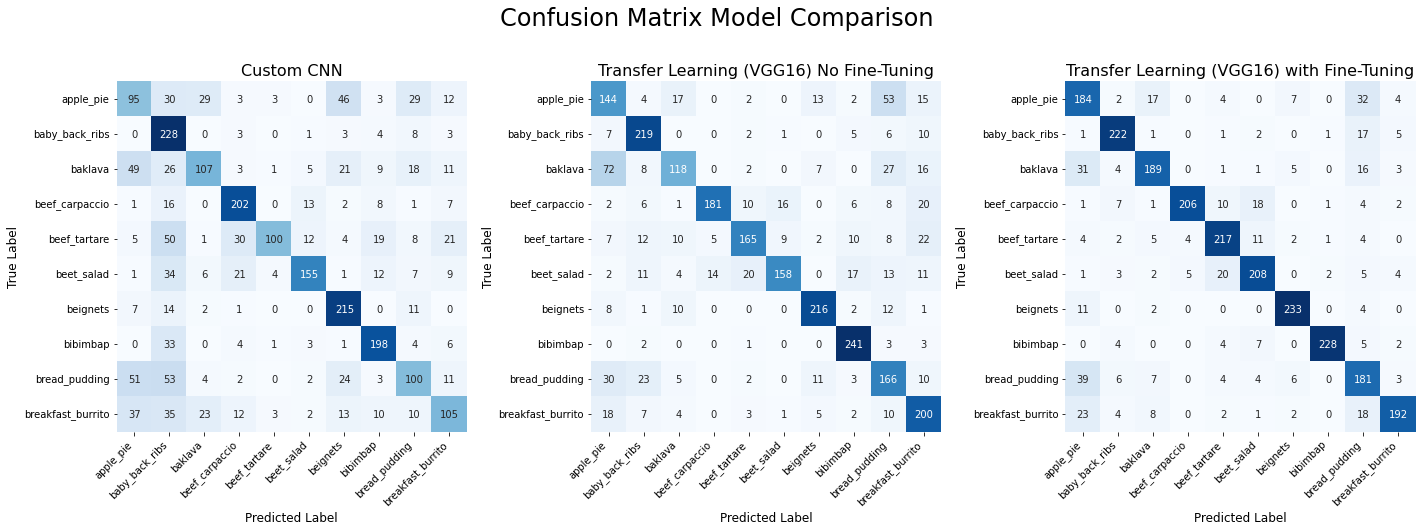

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Get the names of the ten classes
class_names = testgen.class_indices.keys()

def plot_heatmap(y_true, y_pred, class_names, ax, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm, 
        annot=True, 
        square=True, 
        xticklabels=class_names, 
        yticklabels=class_names,
        fmt='d', 
        cmap=plt.cm.Blues,
        cbar=False,
        ax=ax
    )
    ax.set_title(title, fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=12)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))

plot_heatmap(true_classes, scratch_pred_classes, class_names, ax1, title="Custom CNN")    
plot_heatmap(true_classes, vgg_pred_classes, class_names, ax2, title="Transfer Learning (VGG16) No Fine-Tuning")    
plot_heatmap(true_classes, vgg_pred_classes_ft, class_names, ax3, title="Transfer Learning (VGG16) with Fine-Tuning")    

fig.suptitle("Confusion Matrix Model Comparison", fontsize=24)
fig.tight_layout()
fig.subplots_adjust(top=1.25)
plt.show()